# Modeling

We are finally ready to build our models.

In this notebook we want to try 3 different models:
- a linear model
- a tree-based boosting model
- an AutoML model

These can be simple implemented in AWS Sagemaker as they are built-in algorithms.

All of them expect data in this format:
- headerless
- target/label in the first column

Let's first verify that we have data in this format.

In [2]:
# we use the same bucket for reading data and write model outputs
read_bucket = write_bucket =  "ds-houseprices"

# here we have our input data, already splitted in train, validation, test
# headerless with target in the first column
# each folder can contain multiple .csv files
read_prefix = f"ETL/ETL_Numeric"
train_data_key = f"{read_prefix}/Train/noheader"
validation_data_key = f"{read_prefix}/Validation/noheader"
test_data_key = f"{read_prefix}/Test/noheader"
train_data_uri = f"s3://{read_bucket}/{train_data_key}"
validation_data_uri = f"s3://{read_bucket}/{validation_data_key}"
test_data_uri = f"s3://{read_bucket}/{test_data_key}"

# here we are going to write the model outputs
write_prefix = f"Modeling"
output_uri = f"s3://{write_bucket}/{write_prefix}/output"

In [3]:
import sagemaker
import boto3

# initialize session, role, s3 client and sagemaker client
sess = sagemaker.Session()
region = sess.boto_region_name
s3_client = boto3.client("s3", region_name=region)
sagemaker_role = sagemaker.get_execution_role()
sagemaker_client = boto3.client("sagemaker")

In [4]:
import pandas as pd

# let's get the first file to show the data structure
first_file_key = s3_client.list_objects(
    Bucket=read_bucket,
    Prefix=train_data_key)["Contents"][0]["Key"]
        
df = pd.read_csv(f"s3://{read_bucket}/{first_file_key}", header=None, nrows=10)
df

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,140000.0,2,5,120.0,2023.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2033.090131
1,150000.0,1,4,70.0,2022.0,8.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2033.090131
2,150000.0,1,4,70.0,2022.0,4.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2033.090131
3,150000.0,1,4,70.0,2022.0,7.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2033.090131
4,180000.0,1,4,110.0,2022.0,10.0,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1784.238502
5,87000.0,1,5,80.0,2021.0,8.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1784.238502
6,87000.0,1,5,80.0,2021.0,8.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1784.238502
7,180000.0,1,4,68.0,2022.0,10.0,3.0,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1604.493959
8,300000.0,0,0,180.0,2022.0,6.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1604.493959
9,195000.0,2,5,130.0,2022.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1340.471661


We can see that data in the .csv is headerless and we have our target (data_price) in the first column.

Now we can start building models.

## Linear Model
To build a linear model we are going to use the LinearLearner built-in algorithm in Sagemaker.

https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html

A Docker image is required to perform training or inference on all SageMaker models.

SageMaker relies on Docker images from the following repos https://github.com/aws/deep-learning-containers, https://github.com/aws/sagemaker-xgboost-container, and https://github.com/aws/sagemaker-scikit-learn-container.

In [5]:
framework = "linear-learner"
container = sagemaker.image_uris.retrieve(framework=framework, region=region)

# linear learner can be used both for classification and regression problems
static_hyperparams = {"predictor_type" : "regressor"}

# let's build the estimator (model) passing the container
linear = sagemaker.estimator.Estimator(
    container,
    sagemaker_role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    output_path=output_uri,
    sagemaker_session=sess,
    hyperparameters=static_hyperparams
)

Let's do a bit of hyperparameter tuning.

This is super convenient using Sagemaker.

In [6]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner, CategoricalParameter

# Setting ranges of hyperparameters to be tuned
hyperparameter_ranges = {
    "l1": ContinuousParameter(1e-7, 1),
    "wd": ContinuousParameter(1e-7, 1),
    "learning_rate": ContinuousParameter(1e-5, 1),
    "mini_batch_size": IntegerParameter(100, 5000),
    "positive_example_weight_mult": ContinuousParameter(1e-5, 1e5),
    "use_bias": CategoricalParameter([True, False])
}

In [7]:
# the objective is minimization of RMSE
objective_metric_name = "validation:rmse"
objective_type = "Minimize"

# Setting up tuner object, we will run 20 different training jobs (one for each combinations of hyperparameters)
tuner = HyperparameterTuner(estimator=linear, 
                            max_jobs=20, 
                            max_parallel_jobs=5, 
                            objective_metric_name=objective_metric_name, 
                            objective_type=objective_type, 
                            hyperparameter_ranges=hyperparameter_ranges)

In [8]:
# let's build the TrainingInput objects we need to pass to the tuner
train_data = sagemaker.inputs.TrainingInput(train_data_uri, content_type="text/csv")
validation_data = sagemaker.inputs.TrainingInput(validation_data_uri, content_type="text/csv")

# let's fit the tuner
tuner.fit(inputs={"train": train_data, "validation": validation_data})
tuner.wait()

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..............................................................................................................................................................................................................................................................................................!
!


When the tuner has completed, we can see the result of each training job.

In [9]:
# Summary of tuning results ordered in descending order of performance
df_tuner = sagemaker.HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.job_name).dataframe()
df_tuner = df_tuner.sort_values("FinalObjectiveValue", ascending=True)
df_tuner

,l1,learning_rate,mini_batch_size,positive_example_weight_mult,use_bias,wd,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,4.350873e-02,0.010922,100.0,5544.203323,True,2.643468e-03,linear-learner-230427-1856-019-04eaa015,Completed,110551.203125,2023-04-27 19:11:23+00:00,2023-04-27 19:20:37+00:00,554.0
14,2.118654e-06,0.089311,470.0,78021.787968,True,2.699003e-05,linear-learner-230427-1856-006-76fdeb9d,Completed,110562.070312,2023-04-27 19:02:15+00:00,2023-04-27 19:06:38+00:00,263.0
17,4.872493e-04,0.025384,528.0,71.131804,False,4.237333e-07,linear-learner-230427-1856-003-fd547387,Completed,110601.578125,2023-04-27 18:57:45+00:00,2023-04-27 19:03:08+00:00,323.0
18,2.449254e-01,0.312842,1822.0,0.279327,True,1.172656e-07,linear-learner-230427-1856-002-b79b48b2,Completed,110696.203125,2023-04-27 18:57:32+00:00,2023-04-27 19:02:35+00:00,303.0
0,1.250935e-03,0.018836,2509.0,0.014262,True,1.417831e-04,linear-learner-230427-1856-020-bebc00e3,Completed,110724.976562,2023-04-27 19:12:17+00:00,2023-04-27 19:14:59+00:00,162.0
6,1.000000e+00,0.023943,2916.0,35754.097011,True,2.742822e-05,linear-learner-230427-1856-014-c35e356c,Completed,110735.695312,2023-04-27 19:08:10+00:00,2023-04-27 19:11:57+00:00,227.0
5,1.000000e+00,0.051938,4212.0,0.026658,True,1.700895e-06,linear-learner-230427-1856-015-b4fc9fa6,Completed,110751.265625,2023-04-27 19:07:41+00:00,2023-04-27 19:11:04+00:00,203.0
13,2.215715e-01,0.005248,4711.0,19.906061,True,2.571160e-03,linear-learner-230427-1856-007-46654bc9,Completed,110761.585938,2023-04-27 19:02:26+00:00,2023-04-27 19:04:38+00:00,132.0
3,1.000000e-07,0.625643,3305.0,0.020547,False,2.582735e-03,linear-learner-230427-1856-017-c9ad2b80,Completed,110799.687500,2023-04-27 19:11:02+00:00,2023-04-27 19:14:55+00:00,233.0
4,1.000000e+00,0.049233,3146.0,0.129400,False,1.144211e-04,linear-learner-230427-1856-016-e2c5fbd8,Completed,110846.320312,2023-04-27 19:09:25+00:00,2023-04-27 19:12:37+00:00,192.0


Now that we have our best tuned model, we would like to use it to predict values for the test set in order to measure its performance.

To do this we need to deploy the model to an endpoint, that we can then use to ask for predictions.

In [10]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer

# get model location
best_train_job_name = tuner.best_training_job()
model_path = output_uri + '/' + best_train_job_name + '/output/model.tar.gz'

# Create a SageMaker model
model = sagemaker.model.Model(model_data=model_path, 
                              role=sagemaker_role, 
                              image_uri=container, 
                              predictor_cls = sagemaker.predictor.Predictor)

# Deploy the best model and get access to a SageMaker Predictor
predictor = model.deploy(initial_instance_count=1, 
                         instance_type="ml.m5.xlarge",
                         serializer=CSVSerializer(),
                         deserializer=CSVDeserializer())

----!

Ok, now that the model is deployed we can ask for predictions.

In [11]:
# This is our test file

test_file_key = s3_client.list_objects(
    Bucket=read_bucket,
    Prefix=test_data_key)["Contents"][0]["Key"]
        
df = pd.read_csv(f"s3://{read_bucket}/{test_file_key}", header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,180000.0,1,4,110.0,2022.0,2.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1784.238502
1,140000.0,1,5,140.0,2022.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1600.498954
2,100000.0,1,3,60.0,2022.0,3.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2403.646851
3,179000.0,1,2,40.0,2022.0,9.0,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2403.646851
4,179000.0,1,2,40.0,2022.0,9.0,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2403.646851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52907,90000.0,1,3,122.0,2022.0,6.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,665.325353
52908,210000.0,1,4,86.0,2023.0,3.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2329.708790
52909,200000.0,2,4,100.0,2023.0,2.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2329.708790
52910,70000.0,1,5,85.0,2022.0,10.0,3.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1285.148234


Of course we need to drop the target column, and also we need to transform data from DataFrame to numpy array

In [12]:
payload = df.drop(df.columns[0], axis=1).values
print(payload)

[[1.00000000e+00 4.00000000e+00 1.10000000e+02 ... 0.00000000e+00
  0.00000000e+00 1.78423850e+03]
 [1.00000000e+00 5.00000000e+00 1.40000000e+02 ... 0.00000000e+00
  0.00000000e+00 1.60049895e+03]
 [1.00000000e+00 3.00000000e+00 6.00000000e+01 ... 0.00000000e+00
  0.00000000e+00 2.40364685e+03]
 ...
 [2.00000000e+00 4.00000000e+00 1.00000000e+02 ... 0.00000000e+00
  0.00000000e+00 2.32970879e+03]
 [1.00000000e+00 5.00000000e+00 8.50000000e+01 ... 0.00000000e+00
  0.00000000e+00 1.28514823e+03]
 [2.00000000e+00 0.00000000e+00 7.60000000e+01 ... 0.00000000e+00
  0.00000000e+00 1.03800492e+04]]


In [13]:
# to get predictions for our whole test set we need to pass data in chunks, because of endpoint network limits
chunk = 5000

def predict_chunks(predictor, values, chunk):
    df_list = []
    for i in range(len(values)//chunk + 1):
        request_values = values[chunk*i:chunk*(i+1)]
        response_values = predictor.predict(request_values)
        df_list.append(pd.DataFrame(response_values, columns=['y_hat']))
    return pd.concat(df_list).reset_index(drop=True)

result = predict_chunks(predictor, payload, chunk)
result

,y_hat
0,171813.0
1,145170.0
2,195733.5
3,153887.0
4,156653.0
...,...
52907,140464.0
52908,177906.5
52909,225125.5
52910,101672.5


In [14]:
linear_df = pd.merge(result, df[[df.columns[0]]], how="inner", left_index=True, right_index=True)
linear_df = linear_df.rename(columns={0:"y_test"})
linear_df = linear_df.apply(pd.to_numeric)
linear_df

,y_hat,y_test
0,171813.0,180000.0
1,145170.0,140000.0
2,195733.5,100000.0
3,153887.0,179000.0
4,156653.0,179000.0
...,...,...
52907,140464.0,90000.0
52908,177906.5,210000.0
52909,225125.5,200000.0
52910,101672.5,70000.0


Let's calculate model performance metrics.

In [15]:
from sklearn.metrics import mean_squared_error

mean_squared_error(linear_df["y_hat"], linear_df["y_test"], squared=False)

113026.84648474086

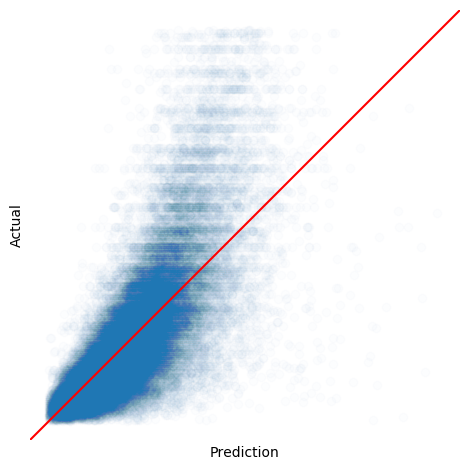

In [16]:
import matplotlib.pyplot as plt

def scatterplot(prediction, actual):
    
    _, ax = plt.subplots()

    ax.scatter(prediction, actual, alpha=0.01)

    plt.axis('square')
    plt.xlabel("Prediction")
    plt.ylabel("Actual")

    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="red")

    plt.tight_layout()

plt_df = linear_df.copy()
plt_df = plt_df[(plt_df["y_hat"] < 1*10**6) & (plt_df["y_test"] < 1*10**6) & (plt_df["y_hat"] > 1*10**4) & (plt_df["y_test"] > 1*10**4)]

scatterplot(plt_df["y_hat"], plt_df["y_test"])
plt.show()

After we are done, let's delete the model and the endpoint to avoid additional charges by AWS Sagemaker.

In [17]:
# Delete model
sess.delete_model(model.name)

# Delete inference endpoint config
sess.delete_endpoint_config(endpoint_config_name=predictor._get_endpoint_config_name())

# Delete inference endpoint
sess.delete_endpoint(endpoint_name=model.endpoint_name)

## Tree-based boosting model

Sagemaker provides 3 different implementation for the gradient boosting decision tree algorithm:
- XGBoost 
- LightGBM
- CatBoost

We are going to use CatBoost in this notebook.

https://docs.aws.amazon.com/sagemaker/latest/dg/catboost.html

CatBoost introduces two critical algorithmic advances to GBDT:
- The implementation of ordered boosting, a permutation-driven alternative to the classic algorithm
- An innovative algorithm for processing categorical features

Both techniques were created to fight a prediction shift caused by a special kind of target leakage present in all currently existing implementations of gradient boosting algorithms.

In [18]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters

train_model_id, train_model_version, train_scope = "catboost-regression-model", "*", "training"
training_instance_type = "ml.m5.xlarge"

# Retrieve the docker image
container = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type
)

# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

# Retrieve the default hyperparameters for training the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# Create SageMaker Estimator instance
estimator = sagemaker.estimator.Estimator(
    role=sagemaker_role,
    image_uri=container,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=output_uri
)

In [19]:
# Setting ranges of hyperparameters to be tuned
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.01),
    "depth": IntegerParameter(4, 10),
    "l2_leaf_reg": IntegerParameter(2, 10),
    "random_strength": ContinuousParameter(0, 10)
}

In [21]:
objective_metric_name = "RMSE"
objective_type = "Minimize"

# Setting up tuner object
tuner = HyperparameterTuner(estimator=estimator,
                           max_jobs=12,
                           max_parallel_jobs=5,
                           objective_metric_name=objective_metric_name,
                           metric_definitions=[{"Name":"RMSE","Regex":"bestTest = ([0-9\\.]+)"}],
                           objective_type=objective_type,
                            hyperparameter_ranges=hyperparameter_ranges
                           )

In [22]:
tuner.fit(inputs={"training": train_data_uri, "validation": validation_data_uri})
tuner.wait()

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...........................................................................................................................!
!


In [23]:
# Summary of tuning results ordered in descending order of performance
df_tuner = sagemaker.HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.job_name).dataframe()
df_tuner = df_tuner.sort_values("FinalObjectiveValue", ascending=True)
df_tuner

,depth,l2_leaf_reg,learning_rate,random_strength,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
7,9.0,7.0,0.009973,9.707508,sagemaker-jumpstart-230427-1933-005-a6d978c7,Completed,88723.914062,2023-04-27 19:34:51+00:00,2023-04-27 19:39:27+00:00,276.0
2,8.0,10.0,0.010000,10.000000,sagemaker-jumpstart-230427-1933-010-a64dd909,Completed,89464.609375,2023-04-27 19:39:47+00:00,2023-04-27 19:43:04+00:00,197.0
5,7.0,10.0,0.009339,6.278969,sagemaker-jumpstart-230427-1933-007-2d362e70,Completed,89821.757812,2023-04-27 19:38:07+00:00,2023-04-27 19:41:09+00:00,182.0
1,7.0,6.0,0.009809,10.000000,sagemaker-jumpstart-230427-1933-011-381e6c7e,Completed,90131.179688,2023-04-27 19:40:52+00:00,2023-04-27 19:43:49+00:00,177.0
10,5.0,3.0,0.009877,6.890697,sagemaker-jumpstart-230427-1933-002-9650cee2,Completed,91596.492188,2023-04-27 19:34:44+00:00,2023-04-27 19:37:51+00:00,187.0
9,7.0,3.0,0.005711,6.204258,sagemaker-jumpstart-230427-1933-003-3c3a06f4,Completed,92993.164062,2023-04-27 19:34:48+00:00,2023-04-27 19:38:25+00:00,217.0
3,8.0,5.0,0.005451,9.665306,sagemaker-jumpstart-230427-1933-009-29a693b8,Completed,93163.507812,2023-04-27 19:39:44+00:00,2023-04-27 19:43:01+00:00,197.0
6,4.0,10.0,0.009136,9.124400,sagemaker-jumpstart-230427-1933-006-18da93fe,Completed,93778.500000,2023-04-27 19:37:49+00:00,2023-04-27 19:40:06+00:00,137.0
0,6.0,3.0,0.004655,10.000000,sagemaker-jumpstart-230427-1933-012-52b89807,Completed,96927.671875,2023-04-27 19:41:07+00:00,2023-04-27 19:43:45+00:00,158.0
11,4.0,8.0,0.005731,1.951968,sagemaker-jumpstart-230427-1933-001-8b7c9330,Completed,97585.406250,2023-04-27 19:34:45+00:00,2023-04-27 19:37:37+00:00,172.0


In [25]:
inference_instance_type = "ml.m5.large"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)

# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

# Deploy the best model and get access to a SageMaker Predictor
predictor = tuner.deploy(initial_instance_count=1, 
                         instance_type=inference_instance_type,
                         entry_point="inference.py",
                         image_uri=deploy_image_uri,
                         source_dir=deploy_source_uri)


2023-04-27 19:39:42 Starting - Preparing the instances for training
2023-04-27 19:39:42 Downloading - Downloading input data
2023-04-27 19:39:42 Training - Training image download completed. Training in progress.
2023-04-27 19:39:42 Uploading - Uploading generated training model
2023-04-27 19:39:42 Completed - Resource reused by training job: sagemaker-jumpstart-230427-1933-009-29a693b8
-----!

Now that our tuner has finished training, we can ask for predictions!

In [26]:
test_file_key = s3_client.list_objects(
    Bucket=read_bucket,
    Prefix=test_data_key)["Contents"][0]["Key"]
        
df = pd.read_csv(f"s3://{read_bucket}/{test_file_key}", header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,180000.0,1,4,110.0,2022.0,2.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1784.238502
1,140000.0,1,5,140.0,2022.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1600.498954
2,100000.0,1,3,60.0,2022.0,3.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2403.646851
3,179000.0,1,2,40.0,2022.0,9.0,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2403.646851
4,179000.0,1,2,40.0,2022.0,9.0,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2403.646851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52907,90000.0,1,3,122.0,2022.0,6.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,665.325353
52908,210000.0,1,4,86.0,2023.0,3.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2329.708790
52909,200000.0,2,4,100.0,2023.0,2.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2329.708790
52910,70000.0,1,5,85.0,2022.0,10.0,3.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1285.148234


In [29]:
import numpy as np
import json

content_type = "text/csv"
endpoint_name = predictor.endpoint_name

def query_endpoint(encoded_tabular_data):
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=encoded_tabular_data
    )
    return response

def parse_response(query_response):
    model_predictions = json.loads(query_response["Body"].read())
    return np.array(model_predictions["prediction"])

num_examples, num_columns = df.shape
features = df.drop(df.columns[0], axis=1)

# split the test data into smaller size of batches to query the endpoint due to the large size of test data.
batch_size = 1500
predictions_list = []
for i in np.arange(0, num_examples, step=batch_size):
    query_response_batch = query_endpoint(
        features.iloc[i : (i + batch_size), :].to_csv(header=False, index=False).encode("utf-8")
    )
    predictions_batch = parse_response(query_response_batch)  # prediction probability per batch
    predictions_list.append(predictions_batch)

predictions = np.concatenate(predictions_list, axis=0)
predictions

array([170156.26216492, 175924.04926098, 173905.23895798, ...,
       239692.54589868,  95762.95514955, 511201.71771109])

In [30]:
catboost_df = pd.DataFrame(df[[df.columns[0]]]).rename(columns={0:"y_test"})
catboost_df["y_hat"] = predictions
catboost_df = catboost_df.apply(pd.to_numeric)
catboost_df

,y_test,y_hat
0,180000.0,170156.262165
1,140000.0,175924.049261
2,100000.0,173905.238958
3,179000.0,134523.337582
4,179000.0,131249.183475
...,...,...
52907,90000.0,89331.752986
52908,210000.0,176111.716361
52909,200000.0,239692.545899
52910,70000.0,95762.955150


In [32]:
mean_squared_error(catboost_df["y_hat"], catboost_df["y_test"], squared=False)

88905.25021274763

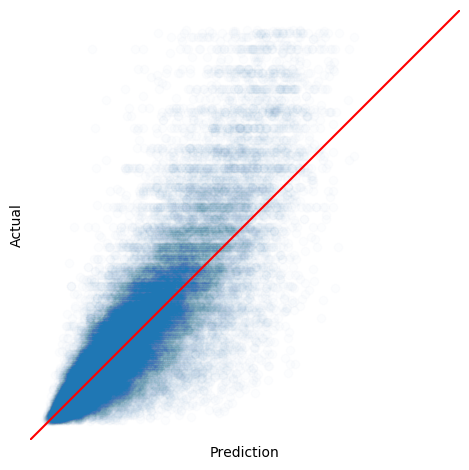

In [33]:
plt_df = catboost_df.copy()
plt_df = plt_df[(plt_df["y_hat"] < 1*10**6) & (plt_df["y_test"] < 1*10**6) & (plt_df["y_hat"] > 1*10**4) & (plt_df["y_test"] > 1*10**4)]

scatterplot(plt_df["y_hat"], plt_df["y_test"])
plt.show()

In [34]:
# Delete inference endpoint config
sess.delete_endpoint_config(endpoint_config_name=predictor._get_endpoint_config_name())

# Delete inference endpoint
sess.delete_endpoint(endpoint_name=predictor.endpoint_name)

## AutoML Model

Automated machine learning (AutoML) is the process of automating the tasks of applying machine learning to real-world problems. AutoML potentially includes every stage from beginning with a raw dataset to building a machine learning model ready for deployment.

Sagemaker provides a built-in AutoML algorithm, called AutoGluon.

AutoGluon-Tabular is a popular open-source AutoML framework that trains highly accurate machine learning models on an unprocessed tabular dataset. Unlike existing AutoML frameworks that primarily focus on model and hyperparameter selection, AutoGluon-Tabular succeeds by ensembling multiple models and stacking them in multiple layers.

https://docs.aws.amazon.com/sagemaker/latest/dg/autogluon-tabular.html

While it can be used directly on raw datasets (with some precautions), we are going to use it on our semi-processed dataset (that contains both numerical and categorical features).

It also needs the dataset to be on a single .csv file, unlike other models.

In [35]:
train_model_id, train_model_version, train_scope = "autogluon-regression-ensemble", "*", "training"
training_instance_type = "ml.g4dn.4xlarge"

# Retrieve the docker image
container = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type
)

# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

# Retrieve the default hyperparameters for training the model
hyperparameters = sagemaker.hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# Create SageMaker Estimator instance
estimator = sagemaker.estimator.Estimator(
    role=sagemaker_role,
    image_uri=container,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=output_uri
)

In [36]:
read_prefix = f"ETL/ETL_Numeric_Categorical"
train_data_key = f"{read_prefix}/Train/noheader"
validation_data_key = f"{read_prefix}/Validation/noheader"
test_data_key = f"{read_prefix}/Test/noheader"
train_data_uri = f"s3://{read_bucket}/{train_data_key}"
validation_data_uri = f"s3://{read_bucket}/{validation_data_key}"
test_data_uri = f"s3://{read_bucket}/{test_data_key}"

In [37]:
estimator.fit(inputs={"training": train_data_uri, "validation": validation_data_uri})

INFO:sagemaker:Creating training-job with name: sagemaker-jumpstart-2023-04-27-19-58-35-972


2023-04-27 19:58:36 Starting - Starting the training job...
2023-04-27 19:58:49 Starting - Preparing the instances for training...
2023-04-27 19:59:42 Downloading - Downloading input data...
2023-04-27 20:00:02 Training - Downloading the training image............
2023-04-27 20:01:53 Training - Training image download completed. Training in progress.....2023-04-27 20:02:46,806 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2023-04-27 20:02:46,829 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"auto_stack":"False","eval_metric":"auto","num_bag_folds":"0","num_bag_sets":"1","num_stack_levels":"0","presets":"medium_quality","refit_full":"False","save_space":"False","set_best_to_refit_full":"False","verbosity":"2"}', 'SM_USER_ENTRY_POINT': 'transfer_learning.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_group_name":"homogeneous

In [38]:
inference_instance_type = "ml.m5.large"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)

# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

predictor = estimator.deploy(initial_instance_count=1, 
                         instance_type=inference_instance_type,
                         entry_point="inference.py",
                         image_uri=deploy_image_uri,
                         source_dir=deploy_source_uri)

INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2023-04-27-21-02-52-080
INFO:sagemaker:Creating endpoint-config with name sagemaker-jumpstart-2023-04-27-21-02-52-080
INFO:sagemaker:Creating endpoint with name sagemaker-jumpstart-2023-04-27-21-02-52-080


-----!

In [39]:
test_file_key = s3_client.list_objects(
    Bucket=read_bucket,
    Prefix=test_data_key)["Contents"][0]["Key"]
        
df = pd.read_csv(f"s3://{read_bucket}/{test_file_key}", header=None)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,180000.0,NaN,NaN,1,unknown,4,110.0,NaN,2022.0,10.0,3.0,agency,0.0,NaN,0.0,quadrilocale,1784.238502
1,177000.0,NaN,NaN,1,unknown,5,121.0,NaN,2022.0,8.0,2.0,agency,0.0,NaN,0.0,terratetto,1060.890547
2,179000.0,NaN,NaN,1,unknown,2,40.0,Nuovo In costruzione,2022.0,9.0,3.0,agency,0.0,NaN,2.0,bilocale,2403.646851
3,129000.0,NaN,NaN,1,unknown,2,40.0,Nuovo In costruzione,2022.0,3.0,1.0,agency,0.0,NaN,0.0,bilocale,2403.646851
4,450000.0,NaN,NaN,1,unknown,4,220.0,Da ristrutturare,2023.0,1.0,0.0,agency,0.0,NaN,NaN,rustico,1850.840270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52798,140000.0,NaN,si,1,unknown,2,75.0,Buono Abitabile,2018.0,8.0,2.0,agency,1.0,box,NaN,bilocale,1201.769441
52799,470000.0,NaN,si,0,unknown,0,163.0,NaN,2022.0,5.0,1.0,agency,1.0,NaN,0.0,appartamento,2996.448886
52800,240000.0,NaN,si,2,si,3,82.0,Ottimo Ristrutturato,2022.0,7.0,2.0,agency,1.0,box,3.0,trilocale,1632.804820
52801,235000.0,NaN,NaN,2,unknown,5,142.0,Ottimo Ristrutturato,2022.0,4.0,1.0,agency,1.0,NaN,0.0,appartamento,1070.980345


In [40]:
content_type = "text/csv"
endpoint_name = predictor.endpoint_name

def query_endpoint(encoded_tabular_data):
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=encoded_tabular_data
    )
    return response

def parse_response(query_response):
    model_predictions = json.loads(query_response["Body"].read())
    return np.array(model_predictions["prediction"])

num_examples, num_columns = df.shape
features = df.drop(df.columns[0], axis=1)

# split the test data into smaller size of batches to query the endpoint due to the large size of test data.
batch_size = 1500
predictions_list = []
for i in np.arange(0, num_examples, step=batch_size):
    query_response_batch = query_endpoint(
        features.iloc[i : (i + batch_size), :].to_csv(header=False, index=False).encode("utf-8")
    )
    predictions_batch = parse_response(query_response_batch)  # prediction per batch
    predictions_list.append(predictions_batch)

predictions = np.concatenate(predictions_list, axis=0)
predictions

array([168670.203125 , 110629.4921875, 130292.5625   , ...,
       154998.5      , 175157.125    , 816258.5      ])

In [41]:
autogluon_df = pd.DataFrame(df[[df.columns[0]]]).rename(columns={0:"y_test"})
autogluon_df["y_hat"] = predictions
autogluon_df = autogluon_df.apply(pd.to_numeric)
autogluon_df

,y_test,y_hat
0,180000.0,168670.203125
1,177000.0,110629.492188
2,179000.0,130292.562500
3,129000.0,124722.804688
4,450000.0,259417.781250
...,...,...
52798,140000.0,89560.421875
52799,470000.0,372231.062500
52800,240000.0,154998.500000
52801,235000.0,175157.125000


In [42]:
mean_squared_error(autogluon_df["y_hat"], autogluon_df["y_test"], squared=False)

79570.54629679606

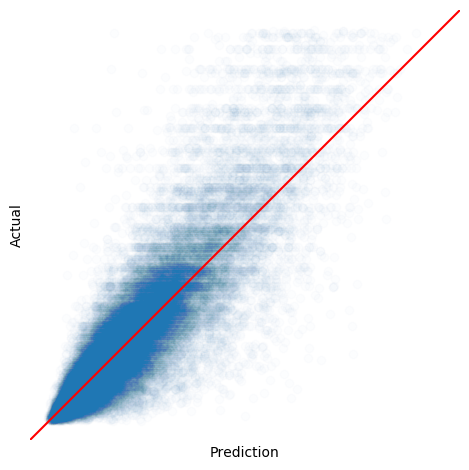

In [43]:
plt_df = autogluon_df.copy()
plt_df = plt_df[(plt_df["y_hat"] < 1*10**6) & (plt_df["y_test"] < 1*10**6) & (plt_df["y_hat"] > 1*10**4) & (plt_df["y_test"] > 1*10**4)]

scatterplot(plt_df["y_hat"], plt_df["y_test"])
plt.show()

In [44]:
# Delete inference endpoint config
sess.delete_endpoint_config(endpoint_config_name=predictor._get_endpoint_config_name())

# Delete inference endpoint
sess.delete_endpoint(endpoint_name=predictor.endpoint_name)

## Conclusion

Let's recap our results (we wanted to optimized for RMSE):
- Basic manual model ~180k
- Slightly more complex manual model ~170k
- **Linear model ~115k**
- **Catboost ~90k**
- AutoGluon ~80k

**Our ML models (especially Catboost) clearly perform better than our baseline benchmark!**

### Further implementations
Possible improvements to our project:

- Improve clustering by taking in consideration also the price per square meter and not only the coordinates to get zones with similar-priced properties
- Use computer vision techniques to feature engineer new features based on the ad images
- Use natural language processing techniques to feature engineer new features based on the ad description
- Get new features based on government websites that publish real estate data
- Get new features based on map data (like distance from nearest university/station/hospital/...)